In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["CUDA_VISIBLE_DEVICES"] = str(2)

import uproot
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import networkx as nx
#from itertools import combinations
#from hausdorff import hausdorff_distance
import copy
import math
import keras
import glob
import sys
import datetime

Using TensorFlow backend.


In [43]:
%matplotlib inline

In [3]:
sys.path += ["../training"]

In [4]:
import pflow

In [84]:
!ls

DiHiggs.ipynb  particleflow.ipynb


In [85]:
Xs_cluster, Xs_track, ys_cand = pflow.load_data("../training/out_*.root")

loading data


In [86]:
len(Xs_cluster)

9000

In [87]:
def to_image(iev, Xs_cluster, Xs_track, ys_cand):
    bins = [np.linspace(-5, 5, 2**8+1), np.linspace(-5, 5, 2**8+1)]
    h_cluster = np.histogram2d(
        Xs_cluster[iev][:, 1],
        Xs_cluster[iev][:, 2],
        weights=Xs_cluster[iev][:, 0],
        bins=bins
    )
    h_track_inner = np.histogram2d(
        Xs_track[iev][:, 1],
        Xs_track[iev][:, 2],
        weights=Xs_track[iev][:, 0],
        bins=bins
    )
    h_track_outer = np.histogram2d(
        Xs_track[iev][:, 3],
        Xs_track[iev][:, 4],
        weights=Xs_track[iev][:, 0],
        bins=bins
    )
    
    h_cand = np.histogram2d(
        ys_cand[iev][:, 1],
        ys_cand[iev][:, 2],
        weights=ys_cand[iev][:, 0],
        bins=bins
    )
    
    h_input = np.stack([h_cluster[0], h_track_inner[0], h_track_outer[0]], axis=-1)
    return h_input, h_cand[0]

In [88]:
h_input, h_output = to_image(0, Xs_cluster, Xs_track, ys_cand)

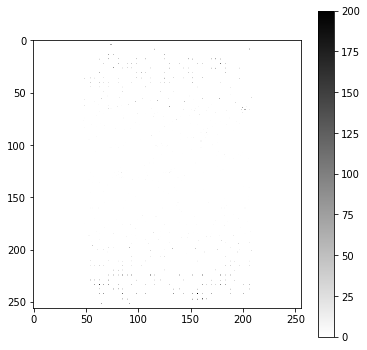

In [89]:
plt.figure(figsize=(6,6))
plt.imshow(h_input[:, :, 0], cmap="binary", vmin=0, vmax=200)
plt.colorbar()

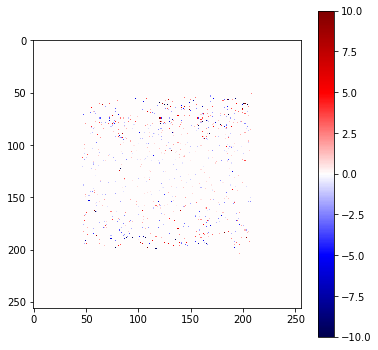

In [90]:
plt.figure(figsize=(6,6))
plt.imshow(h_input[:, :, 1], cmap="seismic", vmin=-10, vmax=10)
plt.colorbar()

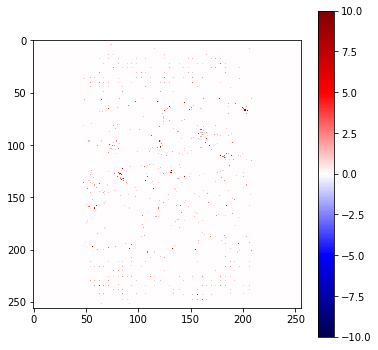

In [91]:
plt.figure(figsize=(6,6))
plt.imshow(h_output[:, :], cmap="seismic", vmin=-10, vmax=10)
plt.colorbar()

In [92]:
data_images_in = []
data_images_out = []
for i in range(len(Xs_cluster)):
    h_in, h_out = to_image(i, Xs_cluster, Xs_track, ys_cand)
    data_images_in += [h_in]
    data_images_out += [h_out]
data_images_in = np.stack(data_images_in, axis=0)
data_images_out = np.stack(data_images_out, axis=0)
data_images_out = data_images_out.reshape((data_images_out.shape[0], data_images_out.shape[1], data_images_out.shape[2], 1))

In [93]:
def myGenerator(batch_size):
    ibatch = 0
    nbatches = data_images_in.shape[0] / batch_size
    while True:
        img_A = data_images_in[ibatch*batch_size:(ibatch+1)*batch_size]
        img_B = data_images_out[ibatch*batch_size:(ibatch+1)*batch_size]
        yield img_A, img_B
        ibatch += 1
        if ibatch == nbatches:
            break

In [110]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

class Pix2Pix():
    def __init__(self):
        # Input shape
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.img_shape_out = (self.img_rows, self.img_cols, 1)

        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 16
        self.df = 16

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        img_in = Input(shape=self.img_shape)
        img_out = Input(shape=self.img_shape_out)

        # By conditioning on B generate a fake version of A
        fake_out = self.generator(img_in)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([img_in, img_out])

        self.combined = Model(inputs=[img_in, img_out], outputs=[valid, fake_out])
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        #d6 = conv2d(d5, self.gf*8)
        #d7 = conv2d(d6, self.gf*8)

        # Upsampling
        #u1 = deconv2d(d7, d6, self.gf*8)
        #u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(d5, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(1, kernel_size=4, strides=1, padding='same', activation='relu')(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape_out)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        
        losses_d = []
        losses_g = [] 

        for epoch in range(epochs):
            for batch_i, (imgs_in, imgs_out) in enumerate(myGenerator(batch_size)):
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                fake_out = self.generator.predict(imgs_in)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_in, imgs_out], valid)
                d_loss_fake = self.discriminator.train_on_batch([imgs_in, fake_out], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_in, imgs_out], [valid, imgs_out])

                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                
            print ("[Epoch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                    d_loss[0], 100*d_loss[1],
                                                                    g_loss[0],
                                                                    elapsed_time))

            losses_d += [d_loss]
            losses_g += [g_loss]
        return losses_d, losses_g

In [111]:
model = Pix2Pix()

In [112]:
model.discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
concatenate_41 (Concatenate)    (None, 256, 256, 4)  0           input_41[0][0]                   
                                                                 input_42[0][0]                   
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 128, 128, 16) 1040        concatenate_41[0][0]             
__________

In [113]:
model.generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_126 (Conv2D)             (None, 128, 128, 16) 784         input_43[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_77 (LeakyReLU)      (None, 128, 128, 16) 0           conv2d_126[0][0]                 
__________________________________________________________________________________________________
conv2d_127 (Conv2D)             (None, 64, 64, 32)   8224        leaky_re_lu_77[0][0]             
__________________________________________________________________________________________________
leaky_re_l

In [ ]:
ret = model.train(epochs=10, batch_size=10)

[Epoch 0/10] [D loss: 0.264195, acc:  34%] [G loss: 2.557206] time: 0:02:16.741485


In [ ]:
plt.plot([r[0] for r in ret[0]])
plt.yscale("log")

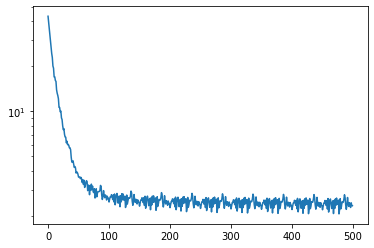

In [79]:
plt.plot([r[0] for r in ret[1]])
plt.yscale("log")

In [ ]:
plt.plot()

In [104]:
p = model.generator.predict(data_images_in[0:1])

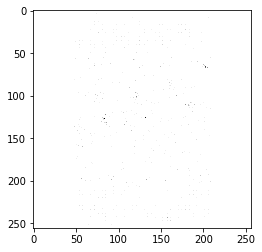

In [105]:
plt.imshow(data_images_out[0, :, :, 0], cmap="binary")

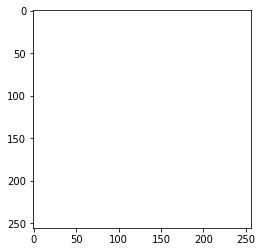

In [106]:
plt.imshow(p[0, :, :, 0], cmap="binary")

In [2]:
def get_index_triu_vector(i, j, vecsize):
    k = j - i - 1
    k += i*vecsize
    missing = int(i*(i+1)/2)
    k -= missing
    return k

In [3]:
fn = "/Users/joosep/Documents/caltech/pfvalidation/out.root"
fi = uproot.open(fn)
tree = fi.get("pftree")
data = tree.arrays(tree.keys())
data = {str(k, 'ascii'): v for k, v in data.items()}

In [22]:
len(data["nclusters"])

10

Text(0.5,0,'number of objects')

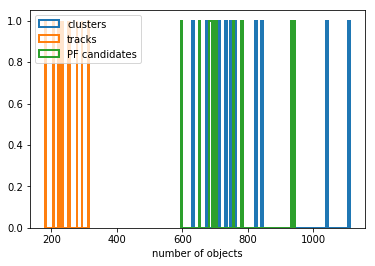

In [23]:
plt.hist(data["nclusters"], bins=100, histtype="step", lw=2, label="clusters");
plt.hist(data["ntracks"], bins=100, histtype="step", lw=2, label="tracks");
plt.hist(data["npfcands"], bins=100, histtype="step", lw=2, label="PF candidates");
plt.legend(loc="best")
plt.xlabel("number of objects")

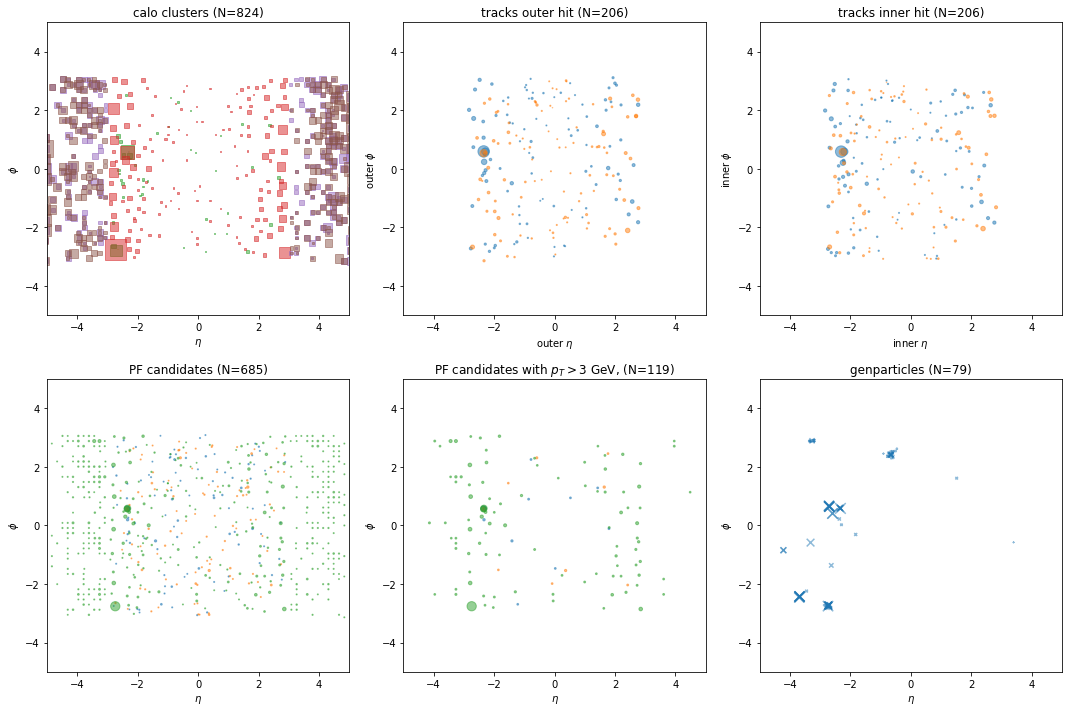

In [24]:
#Event number to plot
i = 2

c_eta = data["clusters_eta"]
c_phi = data["clusters_phi"]
c_en = data["clusters_energy"]
c_type = data["clusters_type"]

t_o_eta = data["tracks_outer_eta"]
t_o_phi = data["tracks_outer_phi"]
t_i_eta = data["tracks_inner_eta"]
t_i_phi = data["tracks_inner_phi"]
t_q = np.sign(data["tracks_qoverp"])
t_en = 1.0/np.abs(data["tracks_qoverp"])

pfcand_ptcut = 3
cand_eta = data["pfcands_eta"]
cand_phi = data["pfcands_phi"]
cand_en = data["pfcands_pt"]
cand_charge = data["pfcands_charge"]

g_eta = data["genparticles_eta"]
g_phi = data["genparticles_phi"]
g_en = data["genparticles_pt"]

plt.figure(figsize=(15,10))

ax = plt.subplot(2,3,1)
for ct in [2,3,4,5,8,9,11]:
    cluster_type_sel = c_type[i]==ct
    plt.scatter(
        c_eta[i][cluster_type_sel],
        c_phi[i][cluster_type_sel],
        s=c_en[i][cluster_type_sel],
        marker="s", alpha=0.5, label="{0}".format(ct))
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")
plt.title("calo clusters (N={0})".format(len(c_eta[i])))
plt.xlim(-5,5)
plt.ylim(-5,5)
#plt.legend(loc="best", ncol=2)

ax = plt.subplot(2,3,2)
for track_charge in [-1, 1]:
    track_charge_sel = t_q[i] == track_charge
    plt.scatter(t_o_eta[i][track_charge_sel], t_o_phi[i][track_charge_sel], s=t_en[i][track_charge_sel], marker="o", alpha=0.5)
plt.xlabel("outer $\eta$")
plt.ylabel("outer $\phi$")
plt.title("tracks outer hit (N={0})".format(len(t_o_eta[i])))
plt.xlim(-5,5)
plt.ylim(-5,5)

ax = plt.subplot(2,3,3)
for track_charge in [-1, 1]:
    track_charge_sel = t_q[i] == track_charge
    plt.scatter(t_i_eta[i][track_charge_sel], t_i_phi[i][track_charge_sel], s=t_en[i][track_charge_sel], marker="o", alpha=0.5)
plt.xlabel("inner $\eta$")
plt.ylabel("inner $\phi$")
plt.title("tracks inner hit (N={0})".format(len(t_o_eta[i])))
plt.xlim(-5,5)
plt.ylim(-5,5)

ax = plt.subplot(2,3,4)
for _cand_charge in [-1, 1, 0]:
    cand_charge_sel = cand_charge[i] == _cand_charge
    plt.scatter(cand_eta[i][cand_charge_sel], cand_phi[i][cand_charge_sel], s=cand_en[i][cand_charge_sel], marker="o", alpha=0.5)
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")
plt.title("PF candidates (N={0})".format(len(cand_eta[i])))
plt.xlim(-5,5)
plt.ylim(-5,5)

ax = plt.subplot(2,3,5)
cand_pt_sel = (cand_en[i] > pfcand_ptcut)
for _cand_charge in [-1, 1, 0]:
    cand_charge_sel = (cand_charge[i] == _cand_charge) & (cand_pt_sel)
    plt.scatter(
        cand_eta[i][cand_charge_sel],
        cand_phi[i][cand_charge_sel],
        s=cand_en[i][cand_charge_sel], marker="o", alpha=0.5)
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")
plt.title("PF candidates with $p_T > {0}$ GeV, (N={1})".format(pfcand_ptcut, len(cand_eta[i][cand_pt_sel])))
plt.xlim(-5,5)
plt.ylim(-5,5)

ax = plt.subplot(2,3,6)
plt.scatter(g_eta[i], g_phi[i], s=g_en[i], marker="x", alpha=0.5)
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")
plt.title("genparticles (N={0})".format(len(g_eta[i])))

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.tight_layout()

In [25]:
from collections import Counter

In [26]:
all_blocks_counts_0 = []
all_blocks_counts_1 = []
all_blocks_counts_2 = []
all_blocks_counts_3 = []

for iev in range(len(data["clusters_iblock"])):
    bls = list(data["clusters_iblock"][iev])
    bls2 = list(data["tracks_iblock"][iev])
    bls_counts = sorted([v for k, v in Counter(bls+bls2).items()], reverse=True)
    all_blocks_counts_0 += [bls_counts[0]]
    all_blocks_counts_1 += [bls_counts[1]]
    all_blocks_counts_2 += [bls_counts[2]]
    all_blocks_counts_3 += [bls_counts[3]]

In [27]:
len(np.unique(list(data["clusters_iblock"][iev]) + list(data["tracks_iblock"][iev])))

761

Text(0.5,0,'elements per block')

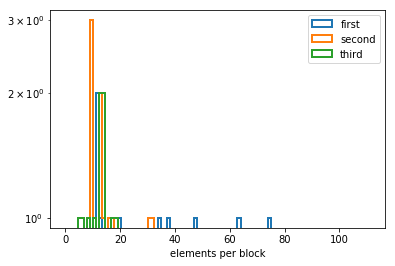

In [28]:
bins = np.linspace(0,1.5*max(all_blocks_counts_0), 100)
plt.hist(all_blocks_counts_0, bins=bins, histtype="step", lw=2, label="first")
plt.hist(all_blocks_counts_1, bins=bins, histtype="step", lw=2, label="second")
plt.hist(all_blocks_counts_2, bins=bins, histtype="step", lw=2, label="third")

plt.yscale("log")
plt.legend(loc="best")
plt.xlabel("elements per block")

In [29]:
tree2 = fi.get("linktree")
linkdata = tree2.arrays(tree2.keys())
linkdata = {str(k, 'ascii'): v for k, v in linkdata.items()}

In [30]:
pfgraph = nx.Graph()
iev = 2

items_block = {}
node_pos = {}
node_colors = {}
node_sizes = {}
node_types = {}

cluster_colors = {
    3: "blue",
    2: "blue",
    5: "red",
    4: "green",
    8: "orange",
    9: "orange",
    11: "purple",
}

for icluster, iblock in enumerate(data["clusters_iblock"][iev]):
    this = (iblock, data["clusters_ielem"][iev][icluster])
    pfgraph.add_node(this)
    
    node_pos[this] = (data["clusters_eta"][iev][icluster], data["clusters_phi"][iev][icluster])
    tp = data["clusters_type"][iev][icluster]
    node_colors[this] = cluster_colors[tp]
    node_sizes[this] = data["clusters_energy"][iev][icluster]
    if not iblock in items_block.keys():
        items_block[iblock] = []
    items_block[iblock] += [this]
    node_types[this] = tp
    
for itrack, iblock in enumerate(data["tracks_iblock"][iev]):
    this = (iblock, data["tracks_ielem"][iev][itrack])
    pfgraph.add_node(this)
    
    p = abs(data["tracks_qoverp"][iev][itrack])
    eta = data["tracks_outer_eta"][iev][itrack]
    phi = data["tracks_outer_phi"][iev][itrack]
    node_pos[this] = (
        eta, phi
    )
    node_colors[this] = "black"
    node_sizes[this] = 10*p
    node_types[this] = 0

    if not iblock in items_block.keys():
        items_block[iblock] = []
    items_block[iblock] += [this]
    
for iblock, items in items_block.items():
    for comb in combinations(items, 2):
        pfgraph.add_edge(comb[0], comb[1])

Text(0,0.5,'$\\phi$')

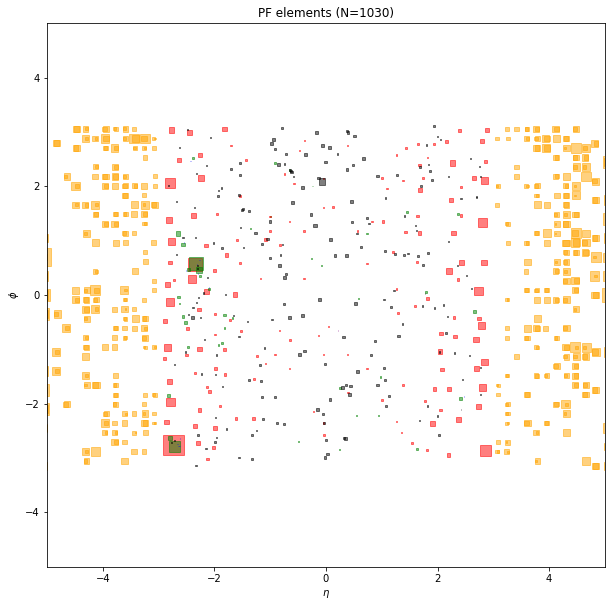

In [31]:
plt.figure(figsize=(10, 10))
plt.xlim(-5,5)
plt.ylim(-5,5)
nx.draw(pfgraph,
        pos=node_pos,
        node_size=[node_sizes[n] for n in pfgraph.nodes],
        node_color=[node_colors[n] for n in pfgraph.nodes],
        edgelist=[],
        node_shape="s",
        alpha=0.5, width=0.05
)
plt.title("PF elements (N={0})".format(len(pfgraph.nodes)))
plt.axis('on')
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")

Text(0,0.5,'$\\phi$')

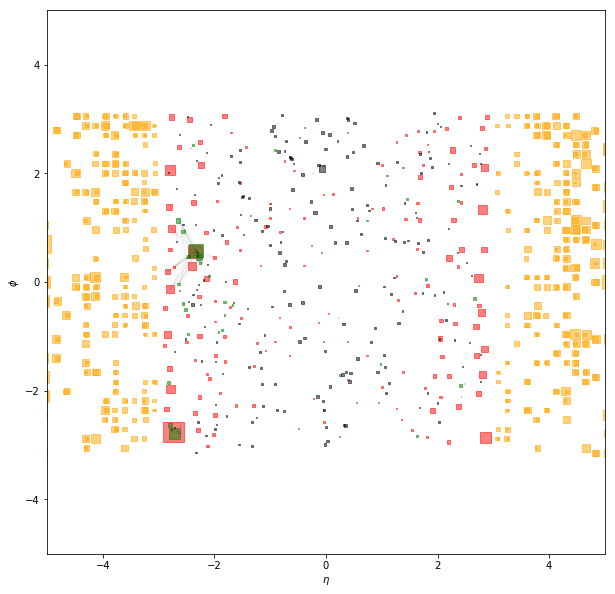

In [32]:
plt.figure(figsize=(10, 10))
plt.xlim(-5,5)
plt.ylim(-5,5)
nx.draw(pfgraph,
        pos=node_pos,
        node_size=[node_sizes[n] for n in pfgraph.nodes],
        node_color=[node_colors[n] for n in pfgraph.nodes],
        node_shape="s",
        alpha=0.5, width=0.001
)
#plt.xticks(np.arange(-5,5,0.3))
#plt.yticks(np.arange(-5,5,0.3))

#plt.grid()
# plt.xlabel("cluster x / scaled track px")
# plt.ylabel("cluster y / scaled track px")
# plt.title("PF elements with blocks")
plt.axis('on')
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")

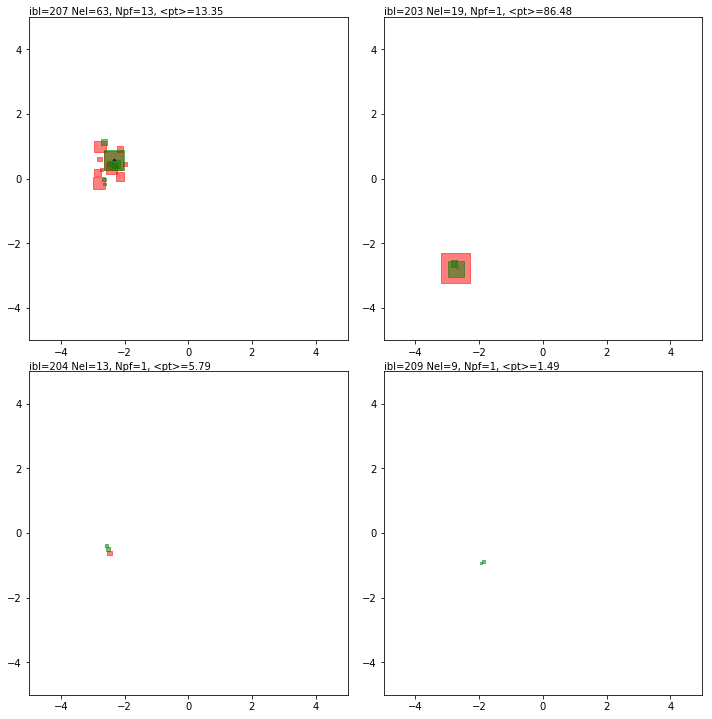

In [33]:
biggest_clusters = sorted([
    (k, items_block[k]) for k in items_block.keys()], reverse=True, key=lambda x: len(x[1])
)[:4]

plt.figure(figsize=(10, 10))
iplot = 1

subs = []
for iblock, elems in biggest_clusters:
    nelem = len(elems)
    
    sub = nx.Graph()
    sub.add_nodes_from(items_block[iblock])
    
    n = linkdata["linkdata_nelem"][iev][linkdata["linkdata_iblock"][iev] == iblock]
    ks = linkdata["linkdata_k"][iev][linkdata["linkdata_iblock"][iev] == iblock]
    dists = linkdata["linkdata_distance"][iev][linkdata["linkdata_iblock"][iev] == iblock]
    kdict = {k: i for i, k in enumerate(ks)}

    vecsize = n[0]
    inds = np.triu_indices(n=vecsize, m=vecsize, k=0.1)
    inds2 = [get_index_triu_vector(i, j, vecsize) for i, j in zip(inds[0], inds[1])]
    for i, ind2 in enumerate(inds2):
        if ind2 in kdict.keys():
            idx_triu_i = inds[0][i]
            idx_triu_j = inds[1][i]
            if idx_triu_j > idx_triu_i:
                tmp = idx_triu_i
                idx_triu_i = idx_triu_j
                idx_triu_j = tmp
            u = (iblock, idx_triu_i)
            v = (iblock, idx_triu_j)
            if u in sub.nodes and v in sub.nodes:
                sub.add_edge(u, v, weight=dists[kdict[ind2]])
    subs += [sub]
    
    ax = plt.subplot(2,2,iplot)

    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

    nx.draw(sub,
            pos=node_pos,
            node_size=[2*node_sizes[n] for n in sub.nodes],
            node_color=[node_colors[n] for n in sub.nodes],
            node_shape="s",
            alpha=0.5, width=0.05, ax=ax
    )
    
    pfcand_inds = (data["pfcands_iblock"][iev] == iblock)
    pf_pt = data["pfcands_pt"][iev][pfcand_inds]
    pf_phi = data["pfcands_phi"][iev][pfcand_inds]
    
    plt.text(0.0, 1.0,
        "ibl={0} Nel={1}, Npf={2}, <pt>={3:.2f}".format(
            iblock, nelem, len(pf_pt), np.mean(pf_pt)),
            transform=ax.transAxes, verticalalignment="bottom")
#     pf_x = 5*pf_pt * np.cos(pf_phi)
#     pf_y = 5*pf_pt * np.sin(pf_phi)
    
#     for ipf in range(len(pf_x)):
#         plt.plot([0, pf_x[ipf]], [0, pf_y[ipf]], color="blue")
    plt.axis('on')
    iplot += 1
    
plt.tight_layout()

In [34]:
iev = 3
track_outer_eta = data["tracks_outer_eta"][iev]
track_outer_phi = data["tracks_outer_phi"][iev]

track_inner_eta = data["tracks_inner_eta"][iev]
track_inner_phi = data["tracks_inner_phi"][iev]

cl_ecal = data["clusters_type"][iev] == 4
cl_ecal_eta = data["clusters_eta"][iev][cl_ecal]
cl_ecal_phi = data["clusters_phi"][iev][cl_ecal]

cl_hcal = data["clusters_type"][iev] == 5
cl_hcal_eta = data["clusters_eta"][iev][cl_hcal]
cl_hcal_phi = data["clusters_phi"][iev][cl_hcal]

cl_hf = data["clusters_type"][iev] >= 8
cl_hf_eta = data["clusters_eta"][iev][cl_hf]
cl_hf_phi = data["clusters_phi"][iev][cl_hf]

(-5, 5)

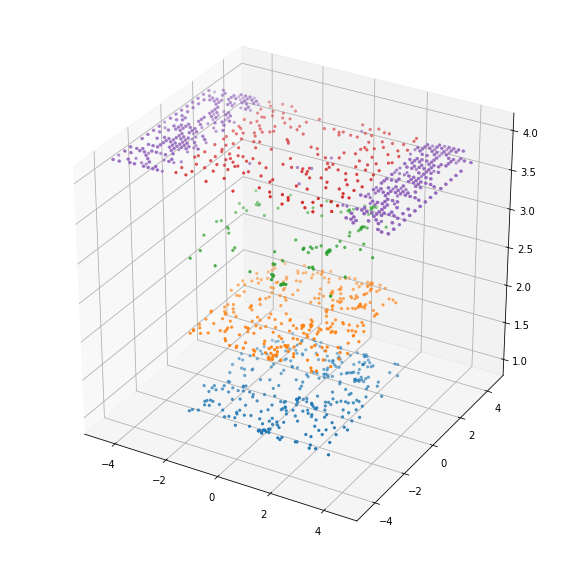

In [35]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(track_inner_eta, track_inner_phi, 1, marker=".")
ax.scatter3D(track_outer_eta, track_outer_phi, 2, marker=".")
ax.scatter3D(cl_ecal_eta, cl_ecal_phi, 3, marker=".")
ax.scatter3D(cl_hcal_eta, cl_hcal_phi, 4, marker=".")
ax.scatter3D(cl_hf_eta, cl_hf_phi, 4, marker=".")

plt.xlim(-5,5)
plt.ylim(-5,5)